In [1]:
from Bio import PDB

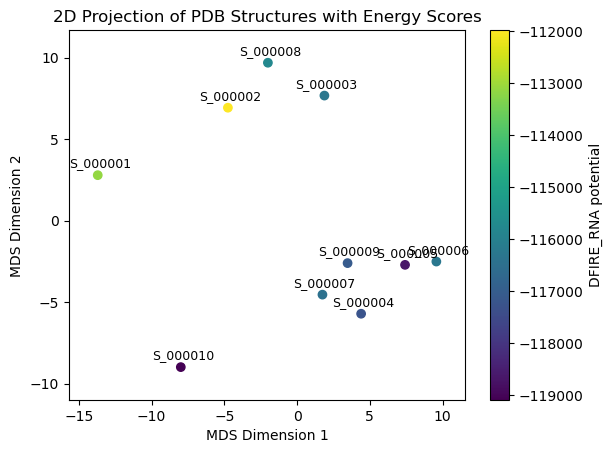

In [42]:
pdb_dir = "../datasets/casp16/R1203_newMXfold2_pdb/R1203_newMXfold2_AF3_pdb"

import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser, Superimposer
from sklearn.manifold import MDS
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# PDBファイルのリスト
pdb_files = [
    "S_000001.pdb", "S_000002.pdb", "S_000003.pdb", "S_000004.pdb",
    "S_000005.pdb", "S_000006.pdb", "S_000007.pdb", "S_000008.pdb",
    "S_000009.pdb", "S_000010.pdb"
]

# RMSD計算用関数
def calculate_rmsd(file1, file2):
    parser = PDBParser()
    structure1 = parser.get_structure('X', os.path.join(pdb_dir, file1))
    structure2 = parser.get_structure('Y', os.path.join(pdb_dir, file2))
    
    atoms1 = [atom for atom in structure1.get_atoms()]
    atoms2 = [atom for atom in structure2.get_atoms()]
    
    sup = Superimposer()
    sup.set_atoms(atoms1, atoms2)
    sup.apply(atoms2)
    
    return sup.rms


def extract_scores(filename):
    import re
    
    scores = []
    with open(filename, 'r') as file:
        for line in file:
            if "SCORE:" in line:
                # スコアの部分を抽出して数値のリストに変換
                score_values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
                scores.append([float(x) for x in score_values][1])
    return scores

# scores = extract_scores(os.path.join(pdb_dir, "scores.txt"))
# label = "FARFAR potential"
# print(scores)

df_scores = pd.read_csv(os.path.join(pdb_dir, "scores/energies_summary.csv"))
scores = df_scores["DFIRE_RNA"]
label = "DFIRE_RNA potential"


# RMSDマトリックスを計算
n = len(pdb_files)
rmsd_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i + 1, n):
        rmsd = calculate_rmsd(pdb_files[i], pdb_files[j])
        rmsd_matrix[i, j] = rmsd
        rmsd_matrix[j, i] = rmsd

# MDSを使用して2Dにプロジェクト
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
coords = mds.fit_transform(rmsd_matrix)

# プロット
plt.scatter(coords[:, 0], coords[:, 1], c=scores, cmap='viridis')
for i in range(n):
    plt.text(coords[i, 0]-2, coords[i, 1]+0.5, os.path.splitext(pdb_files[i])[0], fontsize=9)
plt.xlim(min(coords[:, 0])-2, max(coords[:, 0])+2)
plt.ylim(min(coords[:, 1])-2, max(coords[:, 1])+2)
plt.colorbar(label=label)
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('2D Projection of PDB Structures with Energy Scores')
plt.show()


In [ ]:
# analyze 1000